In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [3]:
housing = pd.read_csv(r'C:\Users\Rog\Desktop\Housing\train.csv')

In [4]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
housing.shape

(1460, 81)

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Check Nulls

<AxesSubplot:>

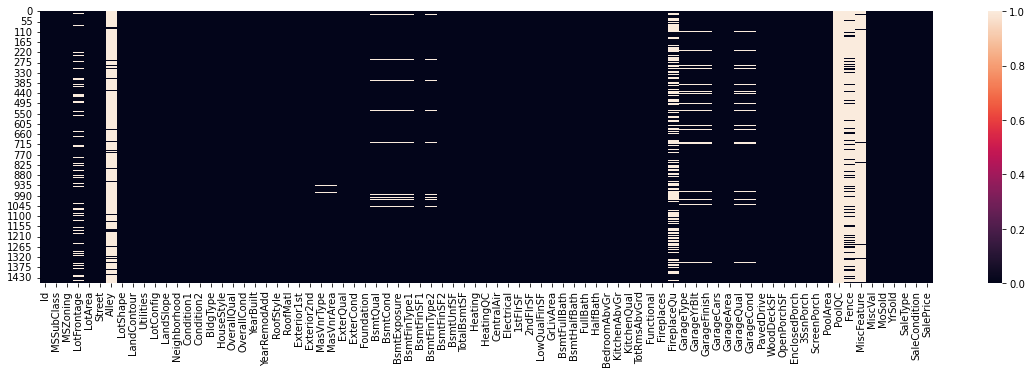

In [8]:
plt.figure(figsize=(20,5))

sns.heatmap(housing.isnull())

<AxesSubplot:>

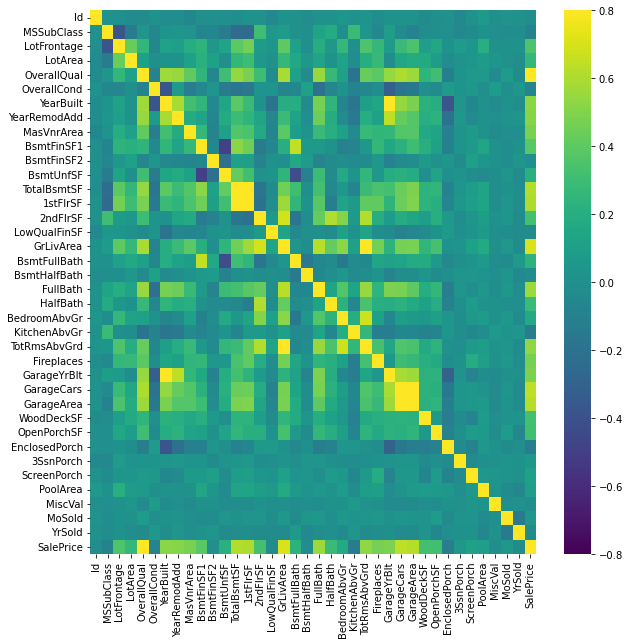

In [9]:
# Check Corr
plt.figure(figsize=(10,10))
sns.heatmap(housing.corr(), cmap='viridis', vmin = -0.8, vmax = 0.8 )

In [10]:
# Lets see the columns with nulls with respective number of nulls and follow one by one
housing.isnull().sum()[housing.isnull().sum() > 0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [11]:
# Remove outliers
housing = housing[housing['GrLivArea'] <  4600]
housing = housing[housing['GarageArea'] < 1230]
housing = housing[housing['BsmtFullBath'] + 0.5 * housing['BsmtHalfBath'] + housing['FullBath'] + 0.5 * housing['HalfBath'] < 5]

In [12]:
# Custom null handilng with mode for one row
housing.at[332 , 'BsmtFinType2'] = "Unf"

In [13]:
y = np.log1p(housing['SalePrice'])
X = housing.drop('SalePrice', axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [14]:
# Impute and create missing indicator fields
def impute(df, col):
    if df[col].dtype == 'O':
        df[col] = df[col].fillna("No")
    else:
        df[col] = df[col].fillna(0)

In [15]:
def process_new(housing):
    # Impute Nulls
    housing = housing.astype({"MSSubClass" : "object", "MoSold" : "object"})
    
    # MasVnrType already has a None value which is also the most popular, so we can fill nulls with it
    housing['MasVnrType'].fillna("None", inplace = True)
    # Fill 1 missing value in Electrical with mode
    housing['Electrical'].fillna(housing['Electrical'].mode(), inplace=True)
    
    c_imp = ['FireplaceQu', 'LotFrontage', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt',
             'GarageArea', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrArea', 'PoolQC',
            'MiscFeature', 'Alley', 'Fence', 'GarageCars', 'TotalBsmtSF', 'KitchenQual', 'BsmtFinSF1', 'BsmtFinSF2',
             'BsmtHalfBath', 'Functional']

    for col in c_imp:
        impute(housing, col)
    
    # Drop unnecessary columns
    housing.drop('Id', axis = 1, inplace = True)
    housing.drop(['Utilities', 'Street'], axis = 1, inplace = True)
    housing.drop(['YearRemodAdd', 'TotRmsAbvGrd', 'BsmtUnfSF'],
                axis = 1, inplace = True)
    
    # Add polynomial
    housing['GrLivArea_2'] = housing['GrLivArea'] ** 2
    housing['GrLivArea_3'] = housing['GrLivArea'] ** 3
    #housing['GarageCars_2'] = housing['GarageCars'] ** 2
    #housing['GarageCars_3'] = housing['GarageCars'] ** 3
    
    return housing

In [16]:
# Encode Features
def encode(housing):
    c_encoded = ['GarageQual', 'GarageCond', 'LotShape', 'Utilities', 'LandSlope', 'ExterQual',
            'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'PavedDrive', 'Neighborhood']
    
    housing['GarageQual'] = housing['GarageQual'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['GarageCond'] = housing['GarageCond'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['LotShape'] = housing['LotShape'].replace({
        'IR3' : 1 , 'IR2' : 2, 'IR1' : 3, 'Reg' : 4
    })

    housing['LandSlope'] = housing['LandSlope'].replace({
        'Gtl' : 1, 'Mod' : 2, 'Sev' : 3
    })

    housing['ExterQual'] = housing['ExterQual'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['ExterCond'] = housing['ExterCond'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['BsmtQual'] = housing['BsmtQual'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['BsmtCond'] = housing['BsmtCond'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['BsmtExposure'] = housing['BsmtExposure'].replace({
        'No' : 0, 'Mn' : 1, 'Av' : 2, 'Gd' : 3
    })

    housing['BsmtFinType1'] = housing['BsmtFinType1'].replace({
        'No' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6
    })

    housing['BsmtFinType2'] = housing['BsmtFinType2'].replace({
        'No' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6
    })

    housing['HeatingQC'] = housing['HeatingQC'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['KitchenQual'] = housing['KitchenQual'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['Functional'] = housing['Functional'].replace({
        'Sal' : 1, 'Sev' : 1, 'Maj1' : 1, 'Maj2' : 1, 'Mod' : 1, 'Min1' : 2, 'Min2' : 3, 'Typ' : 4
    })

    housing['FireplaceQu'] = housing['FireplaceQu'].replace({
        'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5
    })

    housing['GarageFinish'] = housing['GarageFinish'].replace({
        'No' : 0, 'Unf' : 1, 'RFn' : 2, 'Fin' : 3
    })

    housing['PavedDrive'] = housing['PavedDrive'].replace({
        'N' : 0, 'P' : 1, 'Y' : 2
    })
    
    #housing['Neighborhood'] = housing['Neighborhood'].replace({
    #'NoRidge' : 5, 'NridgHt' : 5, 'StoneBr' : 5,
    #'Timber' : 4,'Veenker' : 4,'Somerst' : 4,'ClearCr' : 4,'Crawfor' : 4,
    #'CollgCr' : 3,'Blmngtn' : 3,'Gilbert' : 3,'NWAmes' : 3,'SawyerW'  : 3,
    #'Mitchel' : 2,'NAmes' : 2,'NPkVill' : 2,'SWISU' : 2,'Blueste' : 2,'Sawyer' : 2,'OldTown' : 2,'Edwards' : 2,'BrkSide' : 2,
    #'BrDale' : 1, 'IDOTRR' : 1, 'MeadowV' : 1
    #})
    
    return housing

In [17]:
def feat_eng(housing):
    # Create GarageCars_x_Area and drop
    housing['GarageCars_x_Area'] = housing['GarageCars'] * housing['GarageArea']
    housing.drop(['GarageCars', 'GarageArea'], axis = 1, inplace = True)
    
    # Create 1stFlrSF_x_TotalBsmtSF and drop
    housing['1stFlrSF_x_TotalBsmtSF'] = housing['1stFlrSF'] * housing['TotalBsmtSF']
    housing.drop(['1stFlrSF', 'TotalBsmtSF'], axis = 1, inplace = True)
    
    # Create TotalBath
    housing['TotalBath'] = housing['BsmtFullBath'] + 0.5 * housing['BsmtHalfBath'] + housing['FullBath'] + 0.5 * housing['HalfBath']
    housing.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis = 1, inplace = True)
    
    # Create QualitySum
    columns = ['OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
               'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
    
    housing['QualitySum'] = 0
    for i in columns:
        housing['QualitySum'] += housing[i]
    
    housing['QualitySum'] = housing['QualitySum'] + housing['OverallQual'] ** 2
    
    return housing

In [18]:
def get_scaler(housing):
    # Scale num features
    num_features = housing.select_dtypes(exclude = ["object"]).columns

    scaler = StandardScaler()
    housing.loc[:, num_features] = scaler.fit_transform(housing.loc[:, num_features])
    return housing, scaler

In [19]:
def get_dummies(housing):
    return pd.get_dummies(housing)

In [20]:
X_train = process_new(X_train)
X_train = encode(X_train)
X_train = feat_eng(X_train)
X_train, scaler = get_scaler(X_train)

In [21]:
X_test = process_new(X_test)
X_test = encode(X_test)
X_test = feat_eng(X_test)
num_features = X_test.select_dtypes(exclude = ["object"]).columns
X_test.loc[:, num_features] = scaler.transform(X_test.loc[:, num_features])

In [22]:
X_train = get_dummies(X_train)
X_test = get_dummies(X_test)

In [23]:
dummie_diff_train = list(set(X_test.columns) - set(X_train.columns))
X_train[[dummie_diff_train]] = 0
dummie_diff_test = list(set(X_train.columns) - set(X_test.columns))
X_test[[dummie_diff_test]] = 0

# Model Selection

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [25]:
def predict(X_train, y_train, X_test, y_test, elasticnet_a = 0.01):
    model = []
    rmse = []
    
    # Polynomial
    #polynomial_regression = Pipeline([
    #("poly_features", PolynomialFeatures(degree = 2, include_bias = False)),
    #("lin_reg", LinearRegression())
    #])
    
    #polynomial_regression.fit(X_train, y_train)
    #y_pred = polynomial_regression.predict(X_test)
    
    #model.append('Polynomial')
    #rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # RidgeCV
    ridge_reg = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 13, 17, 22, 30, 60])
    ridge_reg.fit(X_train, y_train)
    y_pred = ridge_reg.predict(X_test)
    
    alpha = ridge_reg.alpha_
    
    model.append('RidgeCV')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # Lasso
    lasso_reg = LassoCV(alphas = [0.001, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 13, 17, 22, 30])
    lasso_reg.fit(X_train, y_train)
    y_pred = lasso_reg.predict(X_test)
    
    model.append('LassoCV')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    
    # LassoLarsCV
    lasso_lars = LassoLarsCV(max_iter = 10000)
    lasso_lars.fit(X_train, y_train)
    y_pred = lasso_lars.predict(X_test)
    
    model.append('LassoLarsCV')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    
    # ElasticNet
    en_reg = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 1],
                        alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 13, 17, 22, 30, 60],
                        max_iter = 50000, cv = 10)
    en_reg.fit(X_train, y_train)
    y_pred = en_reg.predict(X_test)
    
    model.append('ElasticNet')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # SGDRegressor
    # sgd_reg = SGDRegressor()
    # sgd_reg.fit(X_train,y_train)
    # y_pred = sgd_reg.predict(X_test)
    
    # model.append('SGDRegressor')
    # rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # DecisionTreeRegressor
    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(X_train, y_train)
    y_pred = tree_reg.predict(X_test)
    
    model.append('DecisionTreeRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # RandomForestRegressor
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    
    model.append('RandomForestRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # GradientBoostingRegressor
    GBR_reg = GradientBoostingRegressor()
    
    parameters = {
              'learning_rate' : [0.05, 0.1],
              'n_estimators'    : [100, 150, 200]
             }
    
    grid = GridSearchCV(estimator = GBR_reg, param_grid = parameters, cv = 2, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    model.append('GradientBoostingRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # CatBoostRegressor
    cat_reg = CatBoostRegressor()
    
    parameters = {'depth'         : [6],
                  'learning_rate' : [0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }
    
    grid = GridSearchCV(estimator = cat_reg, param_grid = parameters, cv = 2, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    model.append('CatBoostRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    # XGBRegressor
    xgbr_reg = XGBRegressor()
    xgbr_reg.fit(X_train,y_train)
    y_pred = xgbr_reg.predict(X_test)
    
    model.append('XGBRegressor')
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    
    # Move values to DF & Sort ASC
    df = pd.DataFrame()
    df['model'] = model
    df['rmse'] = rmse
    
    df.sort_values('rmse', inplace=True)
    
    # Plot
    plt.figure(figsize = (10,5))
    sns.barplot(x = df['rmse'], y = df['model'])
    plt.show()
    
    print(df)
    return LassoCV

0:	learn: 0.3714289	total: 141ms	remaining: 14s
1:	learn: 0.3488605	total: 143ms	remaining: 7.03s
2:	learn: 0.3272827	total: 145ms	remaining: 4.7s
3:	learn: 0.3098253	total: 147ms	remaining: 3.54s
4:	learn: 0.2911902	total: 149ms	remaining: 2.84s
5:	learn: 0.2764222	total: 151ms	remaining: 2.37s
6:	learn: 0.2619057	total: 153ms	remaining: 2.04s
7:	learn: 0.2483875	total: 155ms	remaining: 1.79s
8:	learn: 0.2368518	total: 157ms	remaining: 1.59s
9:	learn: 0.2264945	total: 159ms	remaining: 1.43s
10:	learn: 0.2165112	total: 161ms	remaining: 1.3s
11:	learn: 0.2075394	total: 162ms	remaining: 1.19s
12:	learn: 0.1992139	total: 164ms	remaining: 1.1s
13:	learn: 0.1915187	total: 165ms	remaining: 1.02s
14:	learn: 0.1847285	total: 167ms	remaining: 947ms
15:	learn: 0.1783075	total: 169ms	remaining: 886ms
16:	learn: 0.1727387	total: 170ms	remaining: 831ms
17:	learn: 0.1683555	total: 172ms	remaining: 783ms
18:	learn: 0.1635031	total: 173ms	remaining: 739ms
19:	learn: 0.1593007	total: 175ms	remaining: 7

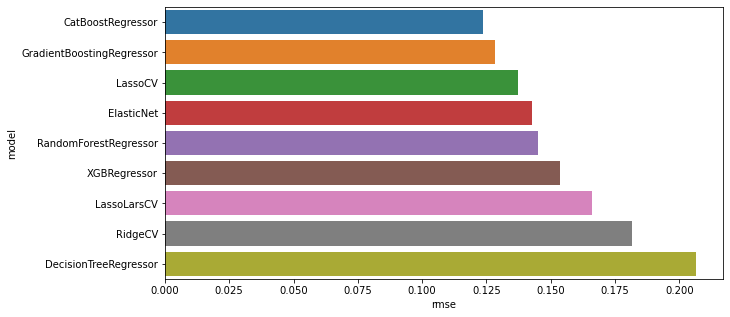

                       model      rmse
7          CatBoostRegressor  0.123682
6  GradientBoostingRegressor  0.128348
1                    LassoCV  0.137288
3                 ElasticNet  0.142826
5      RandomForestRegressor  0.145151
8               XGBRegressor  0.153597
2                LassoLarsCV  0.165905
0                    RidgeCV  0.181808
4      DecisionTreeRegressor  0.206652


sklearn.linear_model._coordinate_descent.LassoCV

In [26]:
predict(X_train, y_train, X_test, y_test)